In [1]:
from collections import defaultdict
from dataclasses import dataclass

# --- 你的动作数据结构 ---
@dataclass
class Scroll:
    name: str
    success_p: float
    atk_value: int
    destroy_on_fail_p: float  # 失败时爆炸概率

SCROLL_A = Scroll("A_10p_+3", success_p=0.11, atk_value=3, destroy_on_fail_p=0.0)
SCROLL_B = Scroll("B_60p_+2", success_p=0.66, atk_value=2, destroy_on_fail_p=0.0)
SCROLL_C = Scroll("C_30p_+3_boom50", success_p=0.33, atk_value=3, destroy_on_fail_p=0.50)
SCROLL_D = Scroll("D_70p_+2_boom50", success_p=0.77, atk_value=2, destroy_on_fail_p=0.50)
SCROLL_SET = {"A": SCROLL_A, "B": SCROLL_B, "C": SCROLL_C, "D": SCROLL_D}

# --- 奖励设计（示例，可按你的业务修改） ---
# 每次卷轴成本
GROVE_SCROLL_PRICE = {
    "A": 33, 
    "B": 597, 
    "C": 14959, 
    "D": 2325
}
# 攻击力的价值
mxb_to_rmb = 56 # 56W mxb = 1rmb
GROVE_ATTACK_PRICE = {
    "10": 1500,
    "11": 2500,
    "12": 5000,
    "13": 14000,
    "14": 41000,
    "15": 2200*mxb_to_rmb,
    "16": 6000*mxb_to_rmb,
    "17": 12500*mxb_to_rmb,
    "18": 2587670,
    "19": 7173121,
    "20": 19882626,
    "21": 55109596
}
# CONSTANT
MAX_ATK = 7 * 3
NUM_SLOTS = 7
TERMINAL_BROKEN = -1      # boom state value

# --- 状态空间：你可以枚举合理上限（例如 0..MAX_ATK）加上 -1 终止状态 ---

def reward_function(s: int, a: str, s_next: int) -> float:
    # s: current attack value
    # a: which scroll to use. "A", "B", "C", "D"
    # s_next: next possible attack value
    # scroll: scroll set
    
    # 基础：动作成本为负
    r = -GROVE_SCROLL_PRICE.get(a)
    # # 爆炸惩罚
    # if s_next == TERMINAL_BROKEN:
    #     r -= GROVE_ATTACK_PRICE.get(str(s), 0)
    return r

# --- 从动作定义构造 MDP 的转移分布 P(s'|s,a) 与期望奖励 R(s,a) ---
def build_transition_and_reward(max_atk: int=MAX_ATK, num_slots: int=NUM_SLOTS):
    S = set()
    S.add(TERMINAL_BROKEN)  # 爆炸终止

    # A[s] contains all possible actions on state s
    A = defaultdict(dict)
    # P[s][a] 是 dict: s' -> prob
    P = defaultdict(lambda: defaultdict(dict))
    # R[s][a] 期望一步奖励（按 s' 加权后的期望）
    R = defaultdict(lambda: defaultdict(dict))
    
    # all possible states at every t
    reachable_by_t = [set() for _ in range(num_slots + 1)]

    def dfs(s:int, slot_used:int):
        # record s
        if s not in S:
            S.add(s)
        
        reachable_by_t[slot_used].add(s)
        # stop when no slots
        if s == TERMINAL_BROKEN or slot_used == num_slots:
            return

        # apply every action
        for a, scroll in SCROLL_SET.items():
            succ = scroll.success_p
            boom_on_fail = scroll.destroy_on_fail_p
            fail = 1.0 - succ

            # three possible s_prime
            s_succ = s + scroll.atk_value
            s_fail = s
            s_boom = TERMINAL_BROKEN
            if s_succ > max_atk: # if attack larger than target number, finish applying action
                continue
            trans = {
                s_succ: succ,                    # 成功
                s_fail: fail * (1-boom_on_fail), # 失败-未爆
                s_boom: fail * boom_on_fail      # 失败-爆炸
            }
            
            # transition probability
            P[s][a] = trans
            
            # actions
            A[s][a] = scroll

            # expected reward
            exp_r = sum(prob * reward_function(s, a, sp) for sp, prob in trans.items())
            R[s][a] = exp_r

           # 递归展开下一步（只对非零概率后继）
            for sp, prob in trans.items():
                if prob > 0.0:
                    dfs(sp, slot_used+1)

    # 从起始状态开始展开
    dfs(0, 0)
    return S, A, P, R, reachable_by_t

def index_states(S):
    states = list(S)
    s2i = {s: i for i, s in enumerate(states)}
    i2s = {i: s for s, i in s2i.items()}
    return states, s2i, i2s

def finite_horizon_dp_with_boom_clear_value(S, A, P, R, T, reachable_by_t=None):
    """
    有限时域 DP：返回
      - V: list[dict[state]->value], t=0..T 的状态值（V[T] 全 0）
      - PI: list[dict[state]->action], t=0..T-1 的最优动作
    """
    if reachable_by_t is None:
        S_pool = [S for _ in range(T + 1)]
    else:
        S_pool = reachable_by_t

    V = [ {s: 0.0 for s in S_pool[t]} for t in range(T + 1) ]
    PI = [ {} for _ in range(T) ]

    def is_term(s):
        # 终止状态，即没有action可用了
        return (s not in A) or (len(A[s]) == 0)

    def clear_value(s):
        # 爆炸时“丢失的价值”（可选用其他函数），这里取清算价
        return GROVE_ATTACK_PRICE.get(str(s), 0.0)

    # 逆推
    for t in reversed(range(T+1)):
        for s in S_pool[t]:  # 该层可达的状态
            V[t][s] = GROVE_ATTACK_PRICE.get(str(s), 0)  # 终止回报
            if t == T:
                continue

            if is_term(s): 
                continue

            if s == TERMINAL_BROKEN:
                continue

            best_a, best_val = None, -float("inf")
            for a in A[s]:
                if a not in P[s]:
                    continue
                
                exp_r = R[s][a] # scroll cost

                cont = 0
                for sp, prob in P[s][a].items():
                    # next possible state and price
                    if sp != TERMINAL_BROKEN:
                        cont += prob * V[t+1][sp]
                    else:
                        cont -= prob * clear_value(s)

                val = exp_r + cont
                if val > best_val:
                    best_val, best_a = val, a

            if best_a is None:
                V[t][s] = GROVE_ATTACK_PRICE.get(str(s), 0)
            else:
                V[t][s] = best_val
                PI[t][s] = best_a

    return V, PI

bellman equation
$$
V_t(s) = \underset{a}{max}(Q_t(s,a))
$$

policy function
$$
Q_t(s,a) = R(s,a) + \sum_{s'}P(s'|s,a)V_{t+1}(s')
$$

In [2]:
import warnings
def get_best_strategy(
    base_attack: int, 
    slot_index: int, 
    target_attack: int):
    S, A, P, R, reachable_by_t = build_transition_and_reward(max_atk=target_attack)
    V, PI = finite_horizon_dp_with_boom_clear_value(S, A, P, R, NUM_SLOTS, reachable_by_t)
    
    scroll_sequence = []
    current_atk = base_attack
    for si in range(slot_index, len(PI)):
        if current_atk not in PI[si]:
            warnings.warn("not best strategy")
            break
        scroll_name = PI[si][current_atk]
        scroll_sequence.append(scroll_name)
        current_atk += SCROLL_SET[scroll_name].atk_value

    return scroll_sequence

# def get_best_strategy(
#     base_attack: list, 
#     slot_index: list, 
#     target_attack: int):
#     S, A, P, R, reachable_by_t = build_transition_and_reward(max_atk=target_attack-base_attack, num_slots=NUM_SLOTS-slot_index)
#     V, PI = finite_horizon_dp_with_boom_clear_value(S, A, P, R, NUM_SLOTS-slot_index, reachable_by_t)
    
#     scroll_sequence = []
#     current_atk = 0
#     for si in range(len(PI)):
#         if current_atk not in PI[si]:
#             break
#         scroll_name = PI[si][current_atk]
#         scroll_sequence.append(scroll_name)
#         current_atk += SCROLL_SET[scroll_name].atk_value

#     return scroll_sequence

In [3]:
S, A, P, R, reachable_by_t = build_transition_and_reward(max_atk=15)
V, PI = finite_horizon_dp_with_boom_clear_value(S, A, P, R, NUM_SLOTS, reachable_by_t)

In [4]:
for i in PI:
    print(i)

{0: 'A'}
{0: 'A', 2: 'A', 3: 'D'}
{0: 'A', 2: 'A', 3: 'A', 4: 'B', 5: 'D', 6: 'B'}
{0: 'A', 2: 'A', 3: 'A', 4: 'A', 5: 'B', 6: 'B', 7: 'D', 8: 'B', 9: 'B'}
{0: 'A', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'B', 8: 'D', 9: 'D', 10: 'B', 11: 'B', 12: 'A'}
{0: 'A', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'B', 10: 'D', 11: 'D', 12: 'A', 13: 'B'}
{0: 'A', 2: 'A', 3: 'A', 4: 'A', 5: 'A', 6: 'A', 7: 'A', 8: 'B', 9: 'B', 10: 'B', 11: 'B', 12: 'D', 13: 'D'}


In [10]:
scroll_sequence = get_best_strategy(3, 1, 15)
print(scroll_sequence)
# ['D', 'D', 'D', 'D', 'D', 'D']

scroll_sequence = get_best_strategy(0, 0, 14)
print(scroll_sequence)
# ['B', 'B', 'B', 'B', 'D', 'D', 'D']

scroll_sequence = get_best_strategy(0, 0, 15)
print(scroll_sequence)
# ['A', 'D', 'D', 'D', 'D', 'D', 'D']

scroll_sequence = get_best_strategy(0, 0, 16)
print(scroll_sequence)
# ['A', 'D', 'D', 'D', 'D', 'D', 'C']

scroll_sequence = get_best_strategy(0, 0, 18)
print(scroll_sequence)

['D', 'D', 'D', 'D', 'D', 'D']
['B', 'B', 'B', 'B', 'D', 'D', 'D']
['A', 'D', 'D', 'D', 'D', 'D', 'D']
['A', 'D', 'D', 'D', 'D', 'D', 'C']
['A', 'D', 'D', 'D', 'C', 'C', 'C']


['A', 'B', 'D', 'D', 'D']
seed: 1758729925


Monte Carlo: 100%|██████████| 100000/100000 [00:41<00:00, 2419.61it/s]



Number of Groves cost: 30.0626
Number of A_10p_+3 cost: 30.0626
Number of D_70p_+2_boom50 cost: 5.1647
Number of B_60p_+2 cost: 3.30472
bad grove value: 0.0
Total Cost 14972.91114


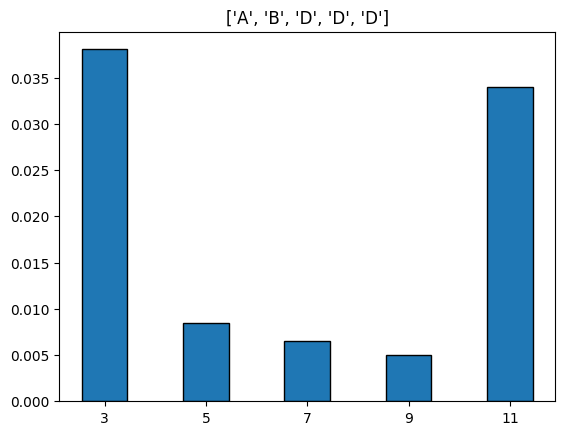

In [6]:
scroll_sequence = get_best_strategy(3, 2, 14)
print(scroll_sequence)

from src.monte_carlo import main, Item
item_state = Item("GoddessGrove", num_slots=5)
main(scroll_sequence, item_state, item_price=0)

seed: 1758730261


Monte Carlo: 100%|██████████| 100000/100000 [00:35<00:00, 2828.05it/s]



Number of Groves cost: 25.83018
Number of A_10p_+3 cost: 25.83018
Number of D_70p_+2_boom50 cost: 8.03241
bad grove value: 0.0
Total Cost 19527.74919


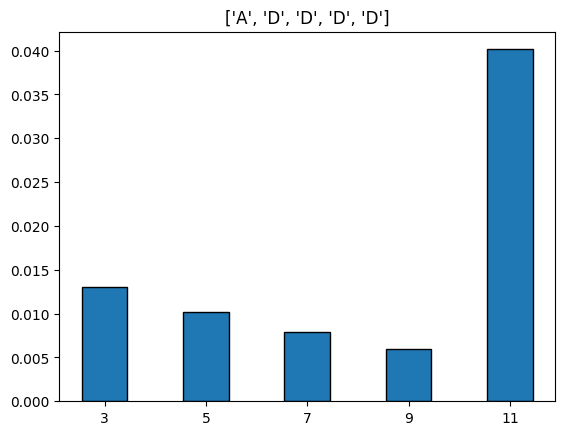

In [9]:
main(['A', 'D', 'D', 'D', 'D'], item_state, item_price=0)

seed: 1758730176


Monte Carlo: 100%|██████████| 100000/100000 [00:12<00:00, 8310.28it/s]



Number of Groves cost: 8.58166
Number of C_30p_+3_boom50 cost: 8.58166
Number of D_70p_+2_boom50 cost: 7.99797
bad grove value: 0.0
Total Cost 146968.33219


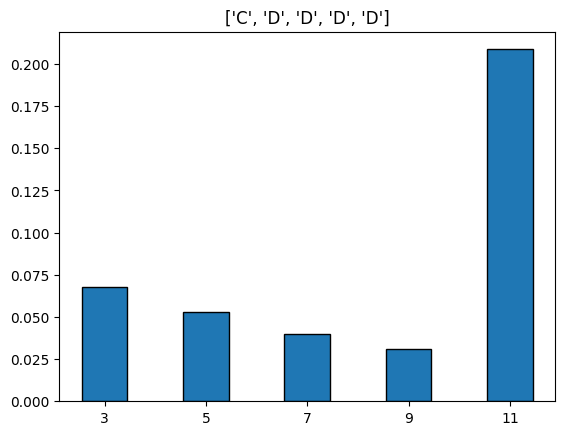

In [7]:
main(['C', 'D', 'D', 'D', 'D'], item_state, item_price=0)

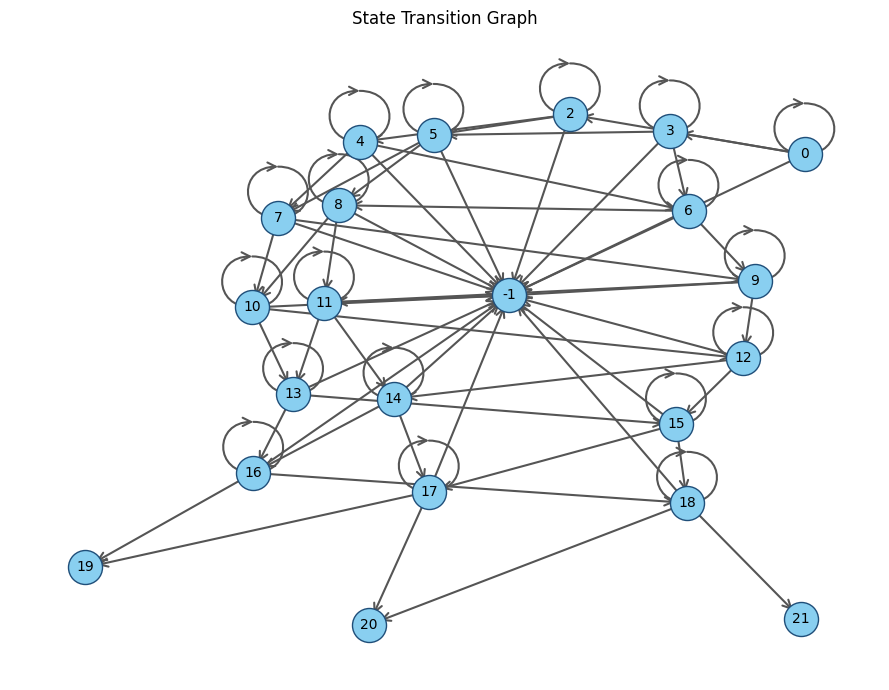

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def build_state_graph(S, P, prob_threshold=0.0):
    """
    将 P[s][a][s'] 汇总为状态图：
    - 节点：S
    - 边：若 sum_a P[s][a][s'] > prob_threshold 则添加边
    - edge attribute: 'weight' 保存概率总和
    """
    G = nx.DiGraph()
    G.add_nodes_from(S)

    for s in P:
        # if s < 10:
        #     continue
        for a in P[s]:
            for sp, prob in P[s][a].items():
                if prob <= 0:
                    continue
                G.add_edge(s, sp, weight=G.get_edge_data(s, sp, default={}).get('weight', 0.0) + prob)

    # 过滤小概率边
    if prob_threshold > 0:
        edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 0.0) < prob_threshold]
        G.remove_edges_from(edges_to_remove)

    return G

def draw_state_graph(G, title="State Transition Graph"):
    # pos = nx.spring_layout(G, seed=42)  # 可换为 shell_layout / kamada_kawai_layout 等
    # pos = nx.spectral_layout(G)
    pos = nx.kamada_kawai_layout(G)
    
    plt.figure(figsize=(9, 7))
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color="#89CFF0", edgecolors="#1f4e79")
    nx.draw_networkx_labels(G, pos, font_size=10)

    # 边与标签（权重保留 3 位小数）
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, width=1.5, edge_color="#555")
    # edge_labels = {(u, v): f"{d.get('weight', 0.0):.3f}" for u, v, d in G.edges(data=True)}
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5)

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def layered_layout(nodes, layer_of, x_gap=1.8, y_gap=1.2):
    # 将同层节点等距排列
    from collections import defaultdict
    layers = defaultdict(list)
    for n in nodes:
        layers[layer_of[n]].append(n)

    pos = {}
    for i, layer in sorted(layers.items()):
        m = len(layer)
        xs = [(j - (m - 1)/2) * x_gap for j in range(m)]
        for x, n in zip(xs, layer):
            pos[n] = (i * y_gap, x)
    return pos
    
# 使用示例
G = build_state_graph(S, P, prob_threshold=0.01)
draw_state_graph(G)

In [12]:
import networkx as nx
import numpy as np

gamma = 0.99
S, A, P, R = build_transition_and_reward(max_atk=MAX_ATK)

# 建图：每个 (s, a) 形成一组出边 s->s'，边属性存 prob 与即时回报（这里回报是期望，直接存在动作上）
G = nx.DiGraph()
for s in S:
    G.add_node(s, terminal=is_terminal_state(s))

for s in S:
    if is_terminal_state(s) or s not in A: 
        continue
    for a, trans in P[s].items():
        # 存边
        for s2, prob in trans.items():
            if prob > 0:
                G.add_edge(s, s2, action=a, prob=prob)
        # 在节点动作层面保存期望奖励
        G.nodes[s].setdefault('actions', {})[a] = R[s][a]

# Value Iteration
V = {s: 0.0 for s in S}
policy = {s: None for s in S}

def bellman_backup(s, V):
    if is_terminal_state(s):
        return 0.0, None
    best_val = -float('inf')
    best_a = None
    for a, exp_r in G.nodes[s].get('actions', {}).items():
        trans = P[s][a]
        exp_v = sum(prob * V[s2] for s2, prob in trans.items())
        qsa = exp_r + gamma * exp_v
        if qsa > best_val:
            best_val, best_a = qsa, a
    return best_val, best_a

tol = 1e-8
for it in range(10_000):
    delta = 0.0
    V_new = {}
    for s in S:
        v, a = bellman_backup(s, V)
        V_new[s] = v
        policy[s] = a
        delta = max(delta, abs(v - V[s]))
    V = V_new
    if delta < tol:
        print(f"Converged in {it+1} iters, delta={delta:.3e}")
        break

print("Optimal policy:")
for s in sorted(S):
    print(f"  state={s:>3} -> {policy[s]}")

Converged in 12 iters, delta=0.000e+00
Optimal policy:
  state= -1 -> None
  state=  0 -> None
  state=  1 -> None
  state=  2 -> None
  state=  3 -> None
  state=  4 -> None
  state=  5 -> None
  state=  6 -> None
  state=  7 -> None
  state=  8 -> None
  state=  9 -> None
  state= 10 -> None
  state= 11 -> None
  state= 12 -> None
  state= 13 -> None
  state= 14 -> None
  state= 15 -> None
  state= 16 -> None
  state= 17 -> None
  state= 18 -> None
  state= 19 -> None
  state= 20 -> None
  state= 21 -> None
